In [71]:
import pandas as pd
import altair as alt
import umap
%matplotlib inline
alt.renderers.enable('notebook')
import imp
hab = imp.load_source('hab', 'hab.py')

In [72]:
!conda list | grep umap
!conda list | grep scikit-learn
!conda list | grep altair
!conda list | grep vega
!conda list | grep pandas

umap-learn                0.3.9                    py37_0    conda-forge
scikit-learn              0.19.1           py37hedc7406_0  
altair                    3.1.0                    py37_0    conda-forge
vega                      2.4.0                    py37_0    conda-forge
pandas                    0.24.2           py37he6710b0_0  


# Load data

## Load names

In [12]:
drug_names_df = pd.read_csv("drug_names.csv", header=None)
drug_names_df.columns = ["drug", "drug_name"]
# rename drugs to conform to ESP subject/object convention
drug_names_df.drug_name = drug_names_df.drug_name.apply(
    lambda x: x.replace(" ", "_").lower())
drug_names_df.head()

,drug,drug_name
0,CID000000085,carnitine
1,CID000000119,gaba
2,CID000000143,leucovorin
3,CID000000158,pge2
4,CID000000159,prostacyclin


In [13]:
# create dictionary for later drug lookup
drug_names = drug_names_df.set_index('drug').to_dict()['drug_name']

side_effect_names_df = pd.read_csv(
    "side_effect_names.tsv", sep='\t', header=None)
side_effect_names_df.columns = ["side_effect", "side_effect_name"]
# rename side effects to conform to ESP predicate convention
side_effect_names_df.side_effect_name = side_effect_names_df.side_effect_name.apply(
    lambda x: x.replace(" ", "_").upper())
side_effect_names_df.head()

,side_effect,side_effect_name
0,C0151714,HYPERMAGNESEMIA
1,C0035344,RETINOPATHY_OF_PREMATURITY
2,C0004144,ATELECTASIS
3,C0002063,ALKALOSIS
4,C0004604,BACK_ACHE


In [14]:
side_effect_names = side_effect_names_df.set_index(
    "side_effect").to_dict()["side_effect_name"]

drug_names['CID000000853'], side_effect_names['C0035344']

('thyroxine', 'RETINOPATHY_OF_PREMATURITY')

## Load splits

In [15]:
file_location = "zenodo/"

# Training data
train_ddi = pd.read_csv(
    file_location + 'decagon_split_train_ddi.tsv', sep="\t", header=None)
train_ppi = pd.read_csv(
    file_location + 'decagon_split_train_ppi.tsv', sep="\t", header=None)
train_drug_protein = pd.read_csv(
    file_location + 'decagon_split_train_drug_protein.tsv', sep="\t", header=None)

# Test data
test_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_test_ddi_pos.tsv', sep="\t", header=None)
test_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_test_ddi_neg.tsv', sep="\t", header=None)

# Validation data
val_ddi_pos = pd.read_csv(
    file_location + 'decagon_split_val_ddi_pos.tsv', sep="\t", header=None)

val_ddi_neg = pd.read_csv(
    file_location + 'decagon_split_val_ddi_neg.tsv', sep="\t", header=None)


In [16]:
side_effect_names_df.head()

,side_effect,side_effect_name
0,C0151714,HYPERMAGNESEMIA
1,C0035344,RETINOPATHY_OF_PREMATURITY
2,C0004144,ATELECTASIS
3,C0002063,ALKALOSIS
4,C0004604,BACK_ACHE


In [17]:
train_ppi.head()

,0,1,2
0,114787,INTERACTS_WITH,375519
1,114787,INTERACTS_WITH,285613
2,114787,INTERACTS_WITH,7448
3,114787,INTERACTS_WITH,4914
4,114787,INTERACTS_WITH,51343


In [18]:
resolve_drug_id = lambda drug_id: drug_names[drug_id] if drug_id in drug_names.keys() else drug_id
resolve_side_effect_id = lambda side_effect_id: side_effect_names[side_effect_id[:-4]]+"-2" if side_effect_id[-3:]=="INV" else side_effect_names[side_effect_id]
fix_predicate = lambda p: p[:-4]+"-2" if p[-3:]=="INV" else p

def resolve_names_ddi_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1].apply(resolve_side_effect_id)
    df['object'] = df[2].apply(resolve_drug_id)

def resolve_names_drug_protein_df(df):
    df['subject'] = df[0].apply(resolve_drug_id)
    df['predicate'] = df[1].apply(fix_predicate)
    df['object'] = df[2]

def resolve_names_protein_protein_df(df):
    df['subject'] = df[0]
    df['predicate'] = df[1].apply(fix_predicate)
    df['object'] = df[2]

## Prep data

### Resolve IDs to names
For readability, resolve drug and side effect IDs to names. No need to resolve protein ids.

In [19]:
print(len(train_ddi))
train_ddi.head()

7323790


,0,1,2
0,CID000002173,C0004144,CID000005651
1,CID000002173,C0004144,CID000003440
2,CID000002173,C0004144,CID000003016
3,CID000002173,C0004144,CID000005538
4,CID000002173,C0004144,CID000004159


In [20]:
train_drug_protein.head()

,0,1,2
0,CID000003345,TARGETS,3757
1,CID000003345,TARGETS,2850
2,CID000003345,TARGETS,4157
3,CID000003345,TARGETS,1902
4,CID000003345,TARGETS,2925


In [21]:
train_ppi.head()

,0,1,2
0,114787,INTERACTS_WITH,375519
1,114787,INTERACTS_WITH,285613
2,114787,INTERACTS_WITH,7448
3,114787,INTERACTS_WITH,4914
4,114787,INTERACTS_WITH,51343


In [22]:
for df in [train_ddi, test_ddi_pos, test_ddi_neg, val_ddi_pos, val_ddi_neg]:
    resolve_names_ddi_df(df)

resolve_names_drug_protein_df(train_drug_protein)

resolve_names_protein_protein_df(train_ppi)

In [23]:
train_ppi.tail()

,0,1,2,subject,predicate,object
2289955,10488,INTERACTS_WITH-INV,10990,10488,INTERACTS_WITH-2,10990
2289956,26580,INTERACTS_WITH-INV,285733,26580,INTERACTS_WITH-2,285733
2289957,6700,INTERACTS_WITH-INV,6701,6700,INTERACTS_WITH-2,6701
2289958,3163,INTERACTS_WITH-INV,54842,3163,INTERACTS_WITH-2,54842
2289959,720,INTERACTS_WITH-INV,440955,720,INTERACTS_WITH-2,440955


In [24]:
train_drug_protein.head()

,0,1,2,subject,predicate,object
0,CID000003345,TARGETS,3757,fentanyl,TARGETS,3757
1,CID000003345,TARGETS,2850,fentanyl,TARGETS,2850
2,CID000003345,TARGETS,4157,fentanyl,TARGETS,4157
3,CID000003345,TARGETS,1902,fentanyl,TARGETS,1902
4,CID000003345,TARGETS,2925,fentanyl,TARGETS,2925


### Create files with training and test data

In [25]:
file_location = ""  # use current directory by default

# All three types of data are used for training
train_ddi.append(train_ppi).append(train_drug_protein)[
    ['subject', 'predicate', 'object']].to_csv(path_or_buf=file_location+"training_examples.tsv", sep='\t', index=False, header=False)

# Use only the ddi data for testing sets
all_test_pos = test_ddi_pos[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_pos = all_test_pos[~all_test_pos.predicate.str.contains("-2")]
all_test_pos.to_csv(path_or_buf=file_location +
                    "positive_examples.tsv", sep='\t', index=False, header=False)

all_test_neg = test_ddi_neg[['subject', 'predicate', 'object']]
# remove reversed side effects for testing
all_test_neg = all_test_neg[~all_test_neg.predicate.str.contains("-2")]
all_test_neg.to_csv(path_or_buf=file_location +
                    "negative_examples.tsv", sep='\t', index=False, header=False)

In [26]:
len(all_test_pos.predicate.unique())

963

### Create files with evaluation strings
For testing, we determine the similarity between the representatation of the drug pair, `S(drug1)*E(drug2)`, and the representation of the side effect, `P(side effect)`. Semanticvectors takes a file with a list of these, one per line.

In [27]:
make_string = lambda row: "S({})*E({})|P({})".format(row.subject, row.object, row.predicate)

positive_test_strings = all_test_pos.apply(make_string, axis=1)
positive_test_strings.to_csv(
    path=file_location+"positive_examples.csv", index=False, header=False)

negative_test_strings = all_test_neg.apply(make_string, axis=1)
negative_test_strings.to_csv(
    path=file_location+"negative_examples.csv", index=False, header=False)

/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  """
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'path' will be renamed to 'path_or_buf'.
  if __name__ == '__main__':


# Train the model
Create the index and train the ESP model with 1024 dimensions for 4 training cycles. This will take a while (depending on hardware, about 1 hour).
The paper used 16,000 dimensions with 8 cycles. This would take about 3.5 hours.

In [32]:
%%bash 
java -cp zenodo/semanticvectors-5.9.jar pitt.search.lucene.LuceneIndexFromTriples training_examples.tsv

java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.ESP -luceneindexpath predication_index -vectortype binary -dimension 1024 -trainingcycles 4 -mutablepredicatevectors -samplingthreshold .00001 -numthreads 60 


Indexing to directory 'predication_index'...


1000 ... 2000 ... 3000 ... 4000 ... 5000 ... 6000 ... 7000 ... 8000 ... 9000 ... 10000 ... 20000 ... 30000 ... 40000 ... 50000 ... 60000 ... 70000 ... 80000 ... 90000 ... 100000 ... 110000 ... 120000 ... 130000 ... 140000 ... 150000 ... 160000 ... 170000 ... 180000 ... 190000 ... 200000 ... 210000 ... 220000 ... 230000 ... 240000 ... 250000 ... 260000 ... 270000 ... 280000 ... 290000 ... 300000 ... 310000 ... 320000 ... 330000 ... 340000 ... 350000 ... 360000 ... 370000 ... 380000 ... 390000 ... 400000 ... 410000 ... 420000 ... 430000 ... 440000 ... 450000 ... 460000 ... 470000 ... 480000 ... 490000 ... 500000 ... 510000 ... 520000 ... 530000 ... 540000 ... 550000 ... 560000 ... 570000 ... 580000 ... 590000 ... 600000 ... 610000 ... 620000 ... 630000 ... 640000 ... 650000 ... 660000 ... 670000 ... 680000 ... 690000 ... 700000 ... 710000 ... 720000 ... 730000 ... 740000 ... 750000 ... 760000 ... 770000 ... 780000 ... 790000 ... 800000 ... 810000 ... 820000 ... 830000 ... 840000 ... 8500

# Evaluation

## Make predictions on test set
This will take a couple of minutes depending on vector dimensionality.

In [68]:
%%bash
# evaluate positive test examples
java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors.bin -semanticvectorfile semanticvectors.bin -elementalpredicatevectorfile predicatevectors.bin -matchcase -searchtype boundproduct < positive_examples.csv > positive_examples_scores.txt

# evaluate negative test examples (generated)
java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors.bin -semanticvectorfile semanticvectors.bin -elementalpredicatevectorfile predicatevectors.bin -matchcase -searchtype boundproduct < negative_examples.csv > negative_examples_scores.txt


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Performance

Positive results mean score: 0.3514403047325436
Negative results mean score: 0.14567324004639148
AUROC: 0.8754618875736471
AUPRC: 0.8387699464607816
AP50: 0.9486667790666597
         median      mean       std       sem       min       max
auroc  0.892222  0.890982  0.025935  0.000836  0.820221  0.972639
auprc  0.860102  0.861588  0.036045  0.001162  0.761114  0.971615
ap50   0.863398  0.855155  0.075460  0.002432  0.554891  1.000000


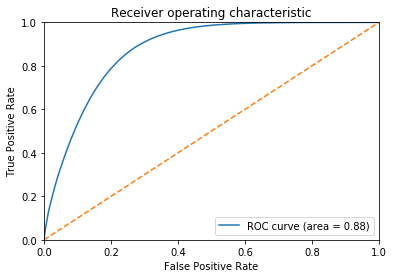

In [28]:
aurocs_by_se = hab.get_aurocs_by_side_effect_files(file_location="./")

In [29]:
aurocs_by_se.head()

,auroc,auprc,ap50,negative_examples,positive_examples
predicate_name,,,,,
ABDOMINAL_DISTENSION,0.861867,0.815635,0.873556,1236,1236
ABDOMINAL_HERNIA,0.933190,0.931417,1.000000,275,275
ABDOMINAL_PAIN,0.852727,0.810896,0.916364,2141,2141
ABDOMINAL_PAIN_UPPER,0.865946,0.824618,0.861845,1316,1316
ABNORMAL_CERVICAL_SMEAR,0.884871,0.838012,0.707330,66,66


In [30]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', aurocs_by_se[c].idxmin(), round(aurocs_by_se[c].min(
    ), 3), 'max:', aurocs_by_se[c].idxmax(), round(aurocs_by_se[c].max(), 3))
    print()

auroc
min: PATENT_DUCTUS_ARTERIOSIS 0.82 max: MUMPS 0.973

auprc
min: CAESAREAN_SECTION 0.761 max: MUMPS 0.972

ap50
min: SINUSITIS 0.555 max: ABDOMINAL_HERNIA 1.0



In [69]:
pos_scores = pd.read_csv(file_location+"positive_examples_scores.txt",
                         header=None).rename(columns={0: 'score'})
pos_scores['truth'] = 1
neg_scores = pd.read_csv(file_location+"negative_examples_scores.txt",
                         header=None).rename(columns={0: 'score'})
neg_scores['truth'] = 0
scores = pos_scores.append(neg_scores)
scores.head()

,score,truth
0,0.232422,1
1,0.255859,1
2,0.203125,1
3,0.406250,1
4,0.029297,1


### Score distribution

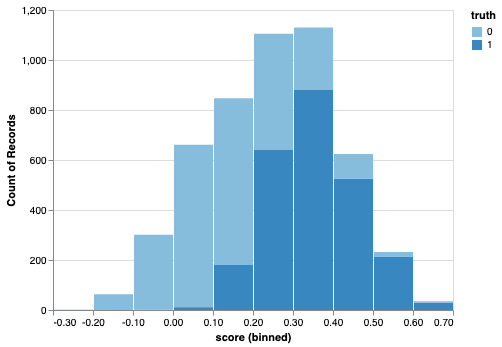

In [70]:
alt.Chart(scores.sample(5000)).mark_bar().encode(
    x=alt.X("score", bin=True), 
    y='count()', 
    color='truth:O'
)

In [33]:
print("Best side effects:")
pd.DataFrame(aurocs_by_se[['auprc']].sort_values(by="auprc",ascending=False).auprc.apply(lambda x: ("%.3f"%x))).head(5)

Best side effects:


,auprc
predicate_name,
MUMPS,0.972
FRACTURE_NONUNION,0.963
DYSHIDROSIS,0.962
SARCOMA,0.958
SCLC,0.954


In [34]:
print("Worst side effects:")
pd.DataFrame(aurocs_by_se[['auprc']].sort_values(by="auprc",ascending=True).auprc.apply(lambda x: ("%.3f"%x))).head(5)

Worst side effects:


,auprc
predicate_name,
CAESAREAN_SECTION,0.761
INTERSTITIAL_NEPHRITIS,0.771
MOUTH_BLEEDING,0.778
EMESIS,0.779
BODY_TEMPERATURE_INCREASED,0.780


Compare to Decagon's best and worst side effects

In [35]:
decagon_reported = pd.DataFrame({"MUMPS" : 0.964,
"BLEEDING" : 0.679,
"CARBUNCLE" : 0.949,
"BODY_TEMPERATURE_INCREASED" : 0.680,
"COCCYDYNIA" : 0.943,
"EMESIS" : 0.693,
"TYMPANIC_MEMBRANE_PERFORATION" : 0.941,
"DISORDER_RENAL" : 0.694,
"DYSHIDROSIS" : 0.938,
"LEUCOPENIA" : 0.695,
"SPONDYLOSIS" : 0.929,
"DIARRHEA" : 0.705,
"SCHIZOAFFECTIVE_DISORDER" : 0.919,
"ICTERUS" : 0.707,
"BREAST_DYSPLASIA" : 0.918,
"NAUSEA" : 0.711,
"GANGLION" : 0.909,
"ITCH" : 0.712,
"UTERINE_POLYP" : 0.908,
"ANAEMIA" : 0.712}, index=['decagon_auprc']).transpose()
decagon_reported.head()

,decagon_auprc
MUMPS,0.964
BLEEDING,0.679
CARBUNCLE,0.949
BODY_TEMPERATURE_INCREASED,0.680
COCCYDYNIA,0.943


In [36]:
best_and_worst = decagon_reported.merge(aurocs_by_se.auprc.rename(
    'esp_auprc'), how='left', left_index=True, right_index=True)
best_and_worst.sort_values(by='decagon_auprc', ascending=False)

,decagon_auprc,esp_auprc
MUMPS,0.964,0.971615
CARBUNCLE,0.949,0.924662
COCCYDYNIA,0.943,0.909737
TYMPANIC_MEMBRANE_PERFORATION,0.941,0.923631
DYSHIDROSIS,0.938,0.961551
SPONDYLOSIS,0.929,0.925978
SCHIZOAFFECTIVE_DISORDER,0.919,0.940407
BREAST_DYSPLASIA,0.918,0.894426
GANGLION,0.909,0.941323
UTERINE_POLYP,0.908,0.893032


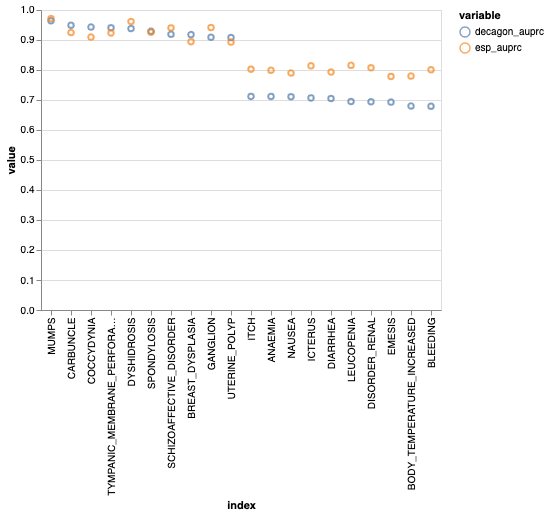

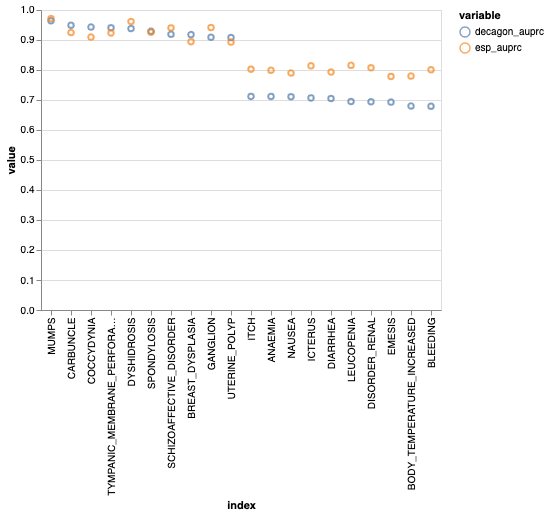

In [37]:
alt.Chart(
    best_and_worst.reset_index().melt(id_vars='index')
).mark_point(
).encode(
    x=alt.X('index', sort=decagon_reported.sort_values(
        by='decagon_auprc', ascending=False).index.tolist()),
    y='value',
    color='variable'
)

## Dimensionality analysis

How low can we go in dimensionality and still preserve acceptable performance?

The below bash script will translate the produced binary vector files into text files, truncate them to the given dimensionalities, turn them back into binary vector files, and evaluate the testing examples with the new vector files. This may take a while (depending on the number of dimensions, at least 3 min).

In [78]:
%%bash
for vectors in elementalvectors semanticvectors predicatevectors
do
    java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -lucenetotext ${vectors}.bin ${vectors}.txt
done

# use appropriate list of dimensions, e.g. 8000 4032 2048 1024 512 256 128 64 
for dimensions in 1024 512 256 128 64 
do
    echo Truncate and evaluate for ${dimensions} dimensions
    SECONDS=0

    # ------ truncate
    for vectors in elementalvectors semanticvectors predicatevectors
    do
        echo "-vectortype BINARY -dimension ${dimensions}" > ${vectors}_truncated.txt
        # take all lines starting at line 2
        tail -n +2 ${vectors}.txt | cut -f 2 -d "|" | cut -c 1-${dimensions} > tmp.txt
        tail -n +2 ${vectors}.txt | cut -f 1 -d "|" > tmp_names.txt
        paste -d "|" tmp_names.txt tmp.txt >> ${vectors}_truncated.txt
        
        java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -texttolucene ${vectors}_truncated.txt ${vectors}_${dimensions}.bin
        rm ${vectors}_truncated.txt

        rm tmp.txt
    done

    # ------ evaluate
    for i in positive negative 
    do
        java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.CompareTermsBatch -elementalvectorfile elementalvectors_${dimensions}.bin -semanticvectorfile semanticvectors_${dimensions}.bin -elementalpredicatevectorfile predicatevectors_${dimensions}.bin -matchcase -searchtype boundproduct < ${i}_examples.csv > ${i}_examples_scores_${dimensions}.txt
    done

    duration=$SECONDS
    echo "$(($duration / 60)) minutes and $(($duration % 60)) seconds elapsed."
done

rm tmp_names.txt

for vectors in elementalvectors semanticvectors predicatevectors 
do
    rm ${vectors}.txt
done

Truncate and evaluate for 1024 dimensions
0 minutes and 53 seconds elapsed.
Truncate and evaluate for 512 dimensions
0 minutes and 47 seconds elapsed.
Truncate and evaluate for 256 dimensions
0 minutes and 36 seconds elapsed.
Truncate and evaluate for 128 dimensions
0 minutes and 26 seconds elapsed.
Truncate and evaluate for 64 dimensions
0 minutes and 23 seconds elapsed.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,mean_auprc,mean_auroc,mean_ap50,auroc_min,auroc_max,auprc_min,auprc_max,ap50_min,ap50_max
1024,0.861588,0.890982,0.855155,0.820221,0.972639,0.761114,0.971615,0.554891,1.0
512,0.862969,0.891065,0.861041,0.816074,0.970139,0.771487,0.966898,0.545857,1.0
256,0.857580,0.885995,0.853782,0.812129,0.962500,0.752808,0.959903,0.510000,1.0
128,0.837682,0.867146,0.847452,0.763294,0.952781,0.708337,0.952394,0.560032,1.0
64,0.809516,0.838952,0.845305,0.713752,0.936528,0.670045,0.922220,0.584712,1.0


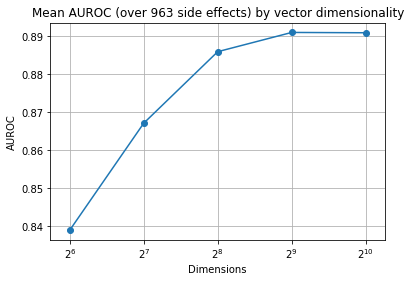

In [38]:
file_location = "./"
metrics = hab.truncation_analysis(
    file_location=file_location, truncation_dimensions=[1024, 512, 256, 128, 64])
metrics

## Umap

In [40]:
%%bash
wget http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
tar -zxvf bio-decagon-effectcategories.tar.gz

./._bio-decagon-effectcategories.csv
bio-decagon-effectcategories.csv


--2019-07-16 23:09:09--  http://snap.stanford.edu/decagon/bio-decagon-effectcategories.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7742 (7.6K) [application/x-gzip]
Saving to: ‘bio-decagon-effectcategories.tar.gz’

     0K .......                                               100% 89.5M=0s

2019-07-16 23:09:09 (89.5 MB/s) - ‘bio-decagon-effectcategories.tar.gz’ saved [7742/7742]



In [41]:
# Load side effect classes
se_classes = pd.read_csv("bio-decagon-effectcategories.csv")
se_classes.columns=['side_effect','side_effect_name','disease_class']
se_classes.side_effect_name = se_classes.side_effect_name.apply(lambda x: x.replace(" ", "_").upper())
print(len(se_classes))
se_classes.head()

561


,side_effect,side_effect_name,disease_class
0,C0017152,GASTRIC_INFLAMMATION,gastrointestinal system disease
1,C0027858,NEUROMA,benign neoplasm
2,C0041466,TYPHOID,bacterial infectious disease
3,C0032807,POST_THROMBOTIC_SYNDROME,cardiovascular system disease
4,C0033860,PSORIASIS,integumentary system disease


In [42]:
# eliminate redundancy
se_classes.disease_class = se_classes.disease_class.apply(lambda x: 'hematopoietic system disease' if x=='hematopoietic system diseases' else x)

In [43]:
se_classes = se_classes.set_index('side_effect_name').disease_class.to_dict()
se_classes

{'GASTRIC_INFLAMMATION': 'gastrointestinal system disease',
 'NEUROMA': 'benign neoplasm',
 'TYPHOID': 'bacterial infectious disease',
 'POST_THROMBOTIC_SYNDROME': 'cardiovascular system disease',
 'PSORIASIS': 'integumentary system disease',
 'AUTONOMIC_NEUROPATHY': 'nervous system disease',
 'PHOBIA': 'cognitive disorder',
 'NEPHROTIC_SYNDROME': 'urinary system disease',
 'MACULA_LUTEA_DEGENERATION': 'nervous system disease',
 'LYMPHOCYTES_DECREASED': 'hematopoietic system disease',
 'HYPOPITUITARISM': 'endocrine system disease',
 'HAEMOLYTIC_ANAEMIA': 'hematopoietic system disease',
 'ARTHRITIS_RHEUMATOID': 'musculoskeletal system disease',
 'PSORIATIC_ARTHRITIS': 'psoriatic arthritis',
 'ANAEMIA': 'hematopoietic system disease',
 'ADYNAMIC_ILEUS': 'gastrointestinal system disease',
 'ANEMIA_APLASTIC': 'hematopoietic system disease',
 'OSTEOCHONDROSIS': 'musculoskeletal system disease',
 'HIV_DISEASE': 'viral infectious disease',
 'ANKYLOSING_SPONDYLITIS': 'musculoskeletal system di

In [91]:
%%bash
for vectors in elementalvectors semanticvectors predicatevectors
do
    java -cp zenodo/semanticvectors-5.9.jar pitt.search.semanticvectors.VectorStoreTranslater -lucenetotext ${vectors}.bin ${vectors}.txt
done

Setting dimension of target config to: 1024
Setting vectortype of target config to: BINARY
Writing term vectors to elementalvectors.txt
About to write 20004 vectors of dimension 1024 to text file: elementalvectors.txt ... finished writing vectors.
Setting dimension of target config to: 1024
Setting vectortype of target config to: BINARY
Writing term vectors to semanticvectors.txt
About to write 20004 vectors of dimension 1024 to text file: semanticvectors.txt ... finished writing vectors.
Setting dimension of target config to: 1024
Setting vectortype of target config to: BINARY
Writing term vectors to predicatevectors.txt
About to write 3860 vectors of dimension 1024 to text file: predicatevectors.txt ... finished writing vectors.


In [44]:
predicate_vectors = pd.read_csv("./predicatevectors.txt", sep="|")
predicate_vectors.head()
predicate_vectors.columns = ['bits']
len(predicate_vectors)

3860

In [45]:
predicate_vectors = predicate_vectors.drop(predicate_vectors.index[predicate_vectors.index.str.endswith(
    "-2") | predicate_vectors.index.str.endswith("-INV")])
predicate_vectors.head()

,bits
PANCREATITIS_RELAPSING,1000010101001111011000111000111000001000001011...
VESTIBULAR_DISORDER,0000110100011111010100111101011100111000001010...
HAIR_DISEASE,1000010101011011011110111001101100101000001011...
CLOTTING,0000100101011111010000101000110100001000011011...
INFLAMMATORY_BOWEL_DISEASE,1001010101011111011000111001100100011000001011...


In [46]:
bit_df = predicate_vectors.bits.apply(lambda x: pd.Series(list(x)))
bit_matrix = bit_df.values

In [47]:
bit_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
PANCREATITIS_RELAPSING,1,0,0,0,0,1,0,1,0,1,...,1,1,0,0,0,1,0,0,0,0
VESTIBULAR_DISORDER,0,0,0,0,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0
HAIR_DISEASE,1,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,0
CLOTTING,0,0,0,0,1,0,0,1,0,1,...,0,1,0,0,1,1,0,1,0,0
INFLAMMATORY_BOWEL_DISEASE,1,0,0,1,0,1,0,1,0,1,...,1,1,0,1,0,1,0,0,0,0


In [52]:
bit_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
HYPERGLYCAEMIA,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,1,0
OPTIC_NEURITIS,1,0,0,0,0,1,0,1,0,1,...,1,1,0,0,1,1,0,1,0,0
RECTAL_PROLAPSE,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,0,0,0
ACUTE_MYELOBLASTIC_LEUKEMIA,0,0,0,1,1,0,0,1,0,0,...,0,1,0,1,1,1,0,0,0,0
ESOPHAGEAL_SPASM,1,0,0,0,0,1,0,1,0,1,...,1,1,0,1,0,1,0,0,0,0


In [48]:
targets = pd.DataFrame(bit_df.index.values)
targets['target'] = targets[0].apply(lambda x: se_classes[x] if x in se_classes else 'other')
targets = targets.set_index(0)
targets.head()

,target
0,
PANCREATITIS_RELAPSING,other
VESTIBULAR_DISORDER,nervous system disease
HAIR_DISEASE,integumentary system disease
CLOTTING,hematopoietic system disease
INFLAMMATORY_BOWEL_DISEASE,gastrointestinal system disease


In [50]:
most_frequent_except_other = targets.target.value_counts().sort_values(ascending=False).reset_index().rename(columns={'target':'count', 'index':'class_name'}).class_name.tolist()[1:]
most_frequent_except_other

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'integumentary system disease',
 'respiratory system disease',
 'cancer',
 'urinary system disease',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'endocrine system disease',
 'viral infectious disease',
 'reproductive system disease',
 'immune system disease',
 'benign neoplasm',
 'fungal infectious disease',
 'cognitive disorder',
 'bacterial infectious disease',
 'developmental disorder of mental health',
 'inherited metabolic disorder',
 'thoracic disease',
 'substance-related disorder',
 'personality disorder',
 'sleep disorder',
 'irritable bowel syndrome',
 'sexual disorder',
 'somatoform disorder',
 'pre-malignant neoplasm',
 'psoriatic arthritis']

In [51]:
import umap, matplotlib.pyplot as plt, numpy as np
points = umap.UMAP(random_state=42).fit_transform(bit_df)

# Optionally t-SNE:
# from sklearn.manifold import TSNE
# points=TSNE(random_state=42).fit_transform(bit_df)

len(points)

/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../anaconda3/envs/jupyter_env/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/haalbu/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=

965

In [53]:
points_df = pd.DataFrame(points)
points_df['group'] = targets.reset_index().target
points_df['side_effect'] = targets.reset_index()[0]
points_df.columns=["x","y",'group','side_effect']
points_df.head()

,x,y,group,side_effect
0,0.792572,2.659610,other,PANCREATITIS_RELAPSING
1,1.184086,0.944349,nervous system disease,VESTIBULAR_DISORDER
2,0.818297,0.293660,integumentary system disease,HAIR_DISEASE
3,5.573890,1.839684,hematopoietic system disease,CLOTTING
4,0.215919,-0.191927,gastrointestinal system disease,INFLAMMATORY_BOWEL_DISEASE


In [54]:
points_df.group.unique()

array(['other', 'nervous system disease', 'integumentary system disease',
       'hematopoietic system disease', 'gastrointestinal system disease',
       'somatoform disorder', 'respiratory system disease',
       'cardiovascular system disease', 'musculoskeletal system disease',
       'bacterial infectious disease', 'fungal infectious disease',
       'substance-related disorder', 'acquired metabolic disease',
       'thoracic disease', 'urinary system disease', 'cancer',
       'endocrine system disease', 'irritable bowel syndrome',
       'cognitive disorder', 'viral infectious disease',
       'reproductive system disease', 'immune system disease',
       'benign neoplasm', 'inherited metabolic disorder',
       'developmental disorder of mental health',
       'pre-malignant neoplasm', 'sexual disorder', 'sleep disorder',
       'personality disorder', 'psoriatic arthritis'], dtype=object)

### Most frequent

In [55]:
groups = most_frequent_except_other[:6]
groups

['nervous system disease',
 'cardiovascular system disease',
 'gastrointestinal system disease',
 'musculoskeletal system disease',
 'integumentary system disease',
 'respiratory system disease']

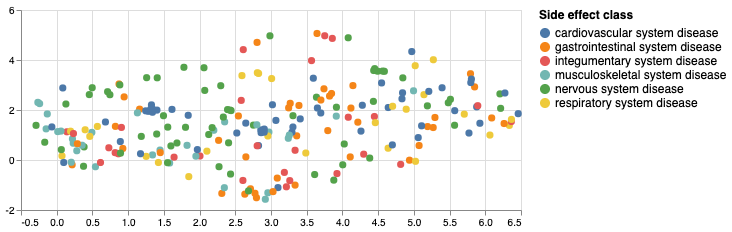

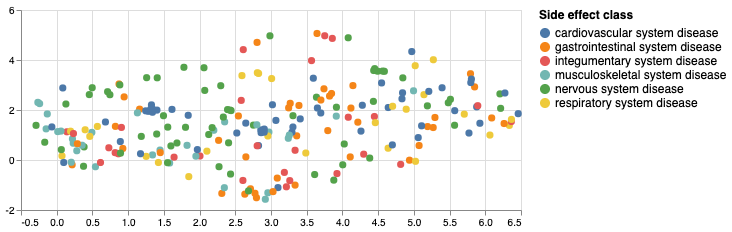

In [56]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title=""),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(width=500, height=200).configure_legend(labelFontSize=12,labelLimit=250,titleFontSize=12)

### Random

In [57]:
groups = pd.DataFrame(most_frequent_except_other).sample(8, random_state=42)[0].tolist()
groups

['pre-malignant neoplasm',
 'cognitive disorder',
 'reproductive system disease',
 'personality disorder',
 'hematopoietic system disease',
 'acquired metabolic disease',
 'substance-related disorder',
 'nervous system disease']

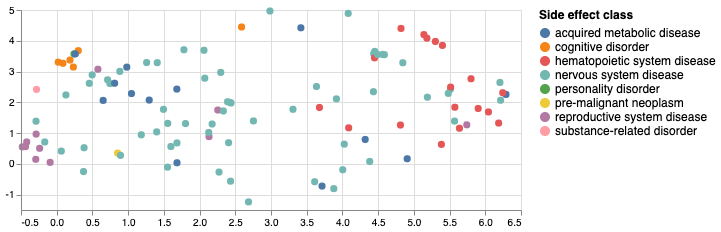

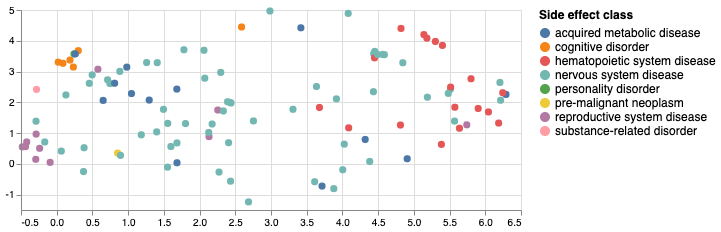

In [58]:
alt.Chart(data=points_df).mark_circle(size=50, opacity=1).encode(
    alt.X("x:Q", title=""),
    alt.Y("y:Q", title=""),
    alt.Color('group:N', title="Side effect class", scale=alt.Scale()),
    alt.Tooltip('side_effect:N')
).transform_filter(
    alt.FieldOneOfPredicate(field='group', oneOf=groups)
).properties(width=500, height=200).configure_legend(labelFontSize=12,labelLimit=250,titleFontSize=12)

### All

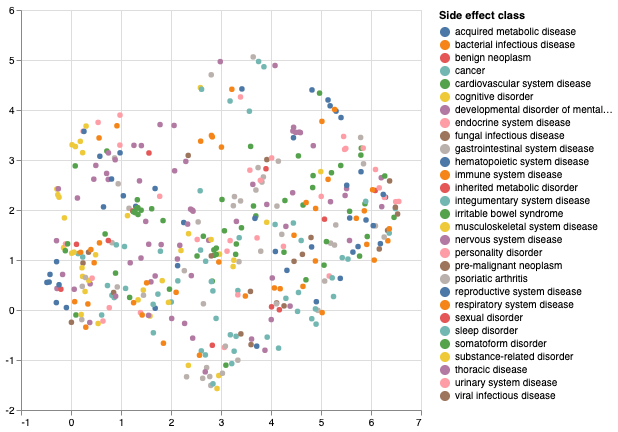

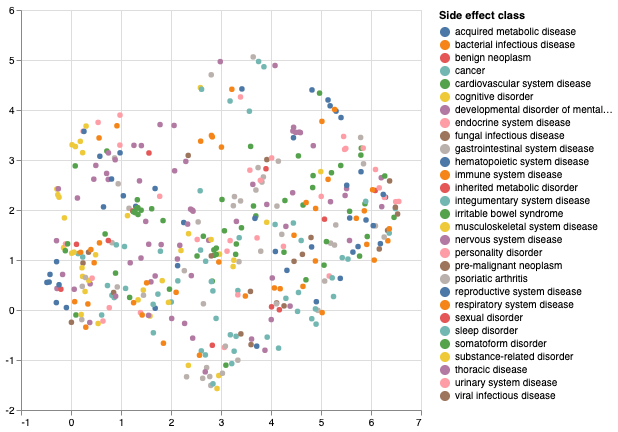

In [59]:
alt.Chart(data=points_df[points_df.group!='other']).mark_circle(opacity=1).encode(
    alt.X("x:Q",title=None),
    alt.Y("y:Q",title=None),
    alt.Color('group:N', title="Side effect class"),
    alt.Tooltip('side_effect:N')
).properties(width=400, height=400)

# Decagon scores

In [60]:
decagon_scores = pd.read_csv(
    "zenodo/decagon_scores_8_epochs.txt", sep="\t")
decagon_scores.columns = ["subject_name",
                          "predicate_name", "object_name", "result", "truth"]
print(decagon_scores.dtypes)
decagon_scores.head()

subject_name       object
predicate_name     object
object_name        object
result            float64
truth             float64
dtype: object


,subject_name,predicate_name,object_name,result,truth
0,CID000002244,C0004144,CID000003365,0.860732,1.0
1,CID000003440,C0004144,CID000004691,0.625638,1.0
2,CID000003957,C0004144,CID000004075,0.691289,1.0
3,CID000004168,C0004144,CID000005090,0.589250,1.0
4,CID000001117,C0004144,CID000077993,0.268906,1.0


In [61]:
[len(decagon_scores), len(
    decagon_scores[~decagon_scores.predicate_name.str.contains("_2")])]

[1828784, 914392]

In [63]:
decagon_scores = decagon_scores[~decagon_scores.predicate_name.str.contains(
    "_2")]
positive_decagon_scores = decagon_scores[decagon_scores.truth == 1]
negative_decagon_scores = decagon_scores[decagon_scores.truth == 0]

positive_examples = positive_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
pos_scores = positive_decagon_scores[['result']]
pos_scores.columns = [0]

negative_examples = negative_decagon_scores[[
    'subject_name', 'predicate_name', 'object_name']]
neg_scores = negative_decagon_scores[['result']]
neg_scores.columns = [0]

[len(positive_examples), len(negative_examples)]

[457196, 457196]

In [64]:
len(decagon_scores.predicate_name.unique())

963

Positive results mean score: 0.6513162997980645
Negative results mean score: 0.19803452504246302
AUROC: 0.8814612398930596
AUPRC: 0.8134662412827647
AP50: 0.5260403973135778
         median      mean       std       sem       min       max
auroc  0.876495  0.855444  0.072896  0.002349  0.259259  0.949018
auprc  0.809637  0.793497  0.066544  0.002144  0.366446  0.934481
ap50   0.647833  0.637958  0.125567  0.004046  0.065504  0.949978


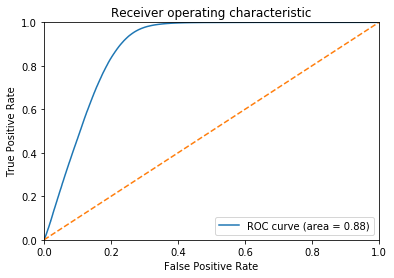

In [65]:
aurocs_by_se = hab.get_aurocs_by_side_effect(
    negative_examples=negative_examples, positive_examples=positive_examples, negative_results=neg_scores, positive_results=pos_scores)

In [66]:
for c in ['auroc', 'auprc', 'ap50']:
    print(c)
    print('min:', side_effect_names[aurocs_by_se[c].idxmin()], round(aurocs_by_se[c].min(
    ), 3), 'max:', side_effect_names[aurocs_by_se[c].idxmax()], round(aurocs_by_se[c].max(), 3))
    print()

auroc
min: HYPERMETROPIA 0.259 max: GASTRIC_ULCER_PERFORATED 0.949

auprc
min: HYPERMETROPIA 0.366 max: GALACTORRHEA 0.934

ap50
min: HYPERMETROPIA 0.066 max: SYNCOPE_VASOVAGAL 0.95

